## DEEP LEARNING FINAL PROJECT##
###Vaishali Shukla###
###Enrollment Id:16325790###


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#importing all necesssary libraries
import os
import zipfile
import numpy as np
import shutil
from PIL import Image
import cv2

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, auc
from scipy.spatial.distance import cosine
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import BatchNormalization
from keras.layers import Input
from keras import regularizers
from keras.models import Model
from keras.optimizers import SGD

from keras.layers import Dropout
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.models import Model
from keras.layers import GlobalAveragePooling2D

In [3]:
# set the paths to the dataset and training/validation directories
data_dir = '/content/drive/MyDrive/GTdbcrop/cropped_faces'
train_dir = '/content/drive/MyDrive/GTdbcrop/train'
valid_dir = '/content/drive/MyDrive/GTdbcrop/valid'


In [ ]:
import os
import shutil

data_dir = '/content/drive/MyDrive/GTdbcrop/cropped_faces'
train_dir = '/content/drive/MyDrive/GTdbcrop/train'
valid_dir = '/content/drive/MyDrive/GTdbcrop/valid'

# Create train and validation folders
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)

# Iterate over subjects
for subject in range(1, 51):
    # Create train and validation subfolders for this subject
    train_subject_dir = os.path.join(train_dir, f'subject{subject}')
    valid_subject_dir = os.path.join(valid_dir, f'subject{subject}')
    os.makedirs(train_subject_dir, exist_ok=True)
    os.makedirs(valid_subject_dir, exist_ok=True)

    # Copy first 10 instances to train folder, and last 5 instances to validation folder
    for instance in range(1, 16):
        src_file = os.path.join(data_dir, f's{subject:02d}_{instance:02d}.jpg')
        if instance <= 10:
            dst_dir = train_subject_dir
        else:
            dst_dir = valid_subject_dir
        dst_file = os.path.join(dst_dir, f's{subject:02d}_{instance:02d}.jpg')
        shutil.copy(src_file, dst_file)


In [4]:
# Load the image
image = cv2.imread('/content/drive/MyDrive/GTdbcrop/train/subject1/s01_10.jpg')

# Get the dimensions of the image
height, width, channels = image.shape

# Print the dimensions
print('Image Dimensions: {} x {} x {}'.format(width, height, channels))

Image Dimensions: 141 x 211 x 3


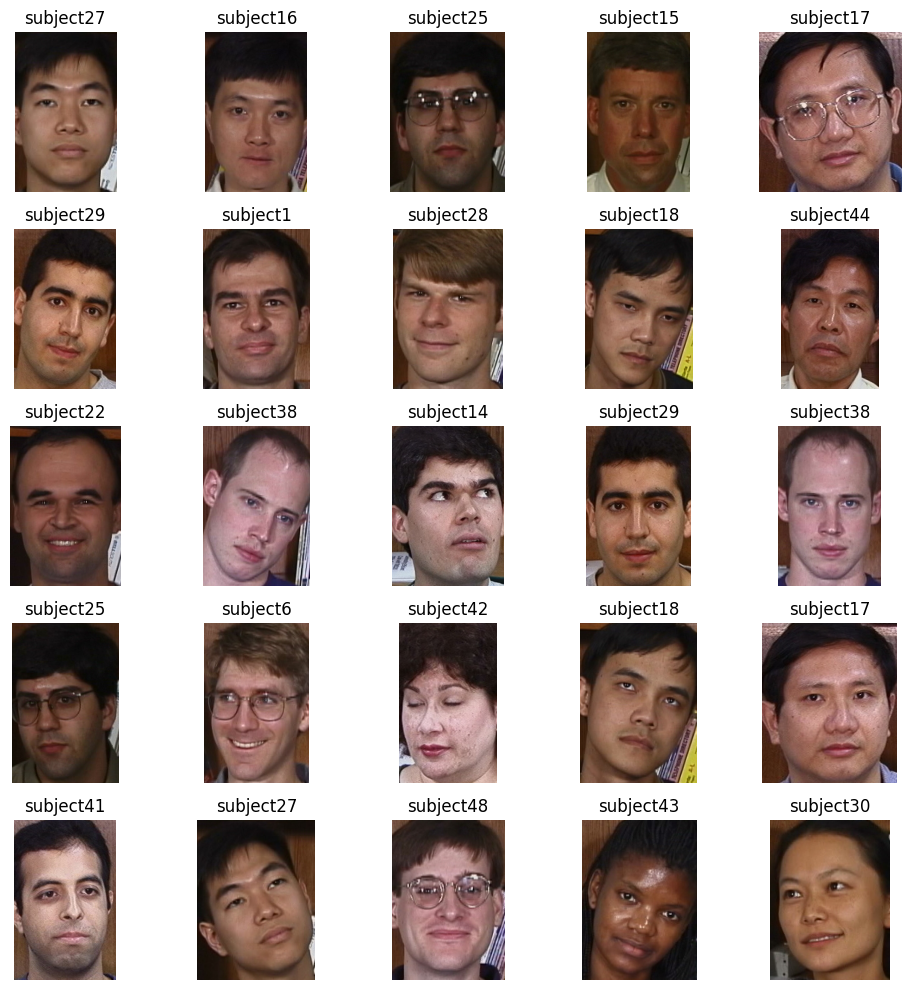

In [5]:
# Define the grid size and figure size
grid_size = 5
fig_size = (10, 10)

# Create the figure and axes objects
fig, axs = plt.subplots(grid_size, grid_size, figsize=fig_size)
axs = axs.ravel()

# Loop through the images and plot them on the grid
for i in range(grid_size*grid_size):
    # Choose a random image
    class_dir = np.random.choice(os.listdir(train_dir))
    img_path = os.path.join(train_dir, class_dir, np.random.choice(os.listdir(os.path.join(train_dir, class_dir))))
    
    # Load the image and plot it on the grid
    img = Image.open(img_path)
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(class_dir)

# Show the grid of images
plt.tight_layout()
plt.show()

###Image Processing###

In [6]:
# Set image size and batch size
img_size = (224, 224)
batch_size = 32

# Create data generators with image augmentation for train and valid sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 500 images belonging to 50 classes.
Found 250 images belonging to 50 classes.


### Fine-tune a VGG19 with 70% of the data and then use fc7 output as features###

In [7]:
# Load pre-trained VGG19 model
base_model = VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size[0], img_size[1], 3)
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
prediction = Dense(50, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=prediction)
#Freeze base model layers
for layer in base_model.layers:
  layer.trainable = False

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Print the model summary
model.summary()


80134624/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [8]:
# Train model on 70% of data
history = model.fit(train_generator, epochs=20, validation_data=valid_generator)

Epoch 1/20
16/16 [==============================] - 615s 39s/step - loss: 4.3017 - accuracy: 0.0140 - val_loss: 3.9074 - val_accuracy: 0.0200
Epoch 2/20
16/16 [==============================] - 571s 36s/step - loss: 3.9167 - accuracy: 0.0180 - val_loss: 3.8875 - val_accuracy: 0.0520
Epoch 3/20
16/16 [==============================] - 564s 36s/step - loss: 3.8498 - accuracy: 0.0460 - val_loss: 3.7091 - val_accuracy: 0.0640
Epoch 4/20
16/16 [==============================] - 563s 36s/step - loss: 3.6518 - accuracy: 0.0540 - val_loss: 3.4298 - val_accuracy: 0.0800
Epoch 5/20
16/16 [==============================] - 536s 34s/step - loss: 3.5142 - accuracy: 0.0580 - val_loss: 3.4656 - val_accuracy: 0.0560
Epoch 6/20
16/16 [==============================] - 563s 36s/step - loss: 3.4076 - accuracy: 0.0980 - val_loss: 3.1875 - val_accuracy: 0.1120
Epoch 7/20
16/16 [==============================] - 562s 36s/step - loss: 3.2388 - accuracy: 0.0840 - val_loss: 3.1521 - val_accuracy: 0.0800
Epoch 

In [33]:
#final evaluation of the model

scores= model.evaluate(valid_generator, verbose=0)
print("Accuracy = %.2f%% " % (scores[1]*100))

Accuracy = 42.40% 


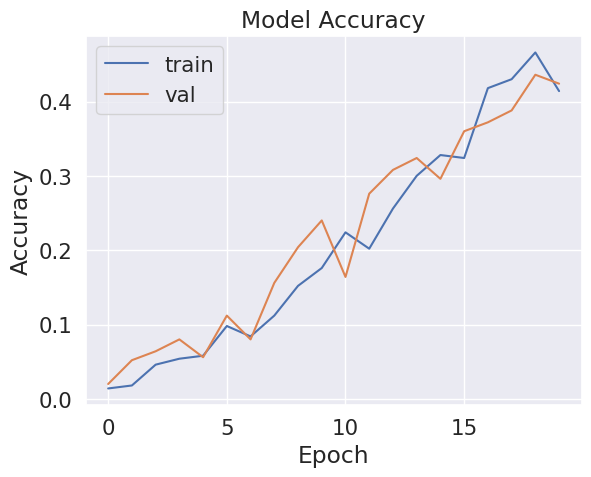

In [34]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

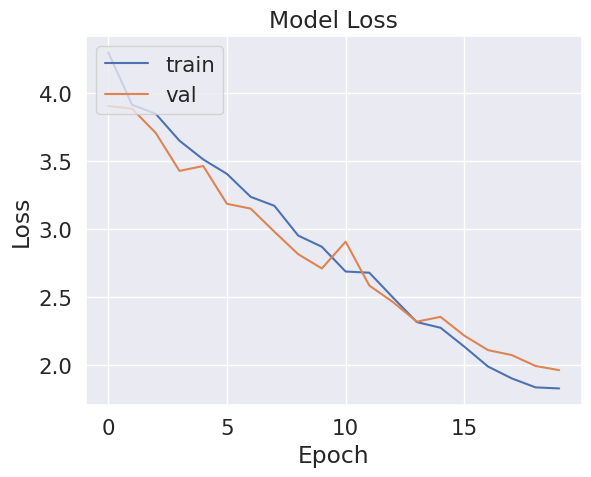

In [35]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
#Saving the model
model.save_weights('model_weights_updated.h5')

In [13]:
# Loading the model 
model.load_weights('/content/model_weights_updated.h5')

In [15]:
# Create a new model that outputs the fc7 features
fc7_layer = model.get_layer('dense_1')
fc7_output = fc7_layer.output
model_fc = Model(inputs=model.input, outputs=fc7_output)

In [16]:
# Set the path to the input image file
img_path = '/content/drive/MyDrive/GTdbcrop/valid/subject1/s01_11.jpg'

# Load and resize the image to the desired input size
img = Image.open(img_path).resize((224, 224))

# Convert the image to a numpy array and add an extra batch dimension
x = np.array(img)[np.newaxis, ...]

# Preprocess the input array for the VGG19 model
x = tf.keras.applications.vgg19.preprocess_input(x)

# Extract features using the fc7 layer of the VGG19 model
features = model_fc.predict(x)

# Print the features
print(features)

1/1 [==============================] - 1s 889ms/step
[[0.         0.         0.         ... 0.91676116 0.         0.        ]]


In [17]:
# Define the paths to the validation dataset
validation_dir = '/content/drive/MyDrive/GTdbcrop/valid'

# Define the batch size for validation data
batch_size = 1

# Get the list of validation image directories
validation_directories = [os.path.join(validation_dir, folder_name) for folder_name in os.listdir(validation_dir)]

# Create an empty list to hold the feature vectors for the validation images
test_features = []

# Loop through the validation image directories
for validation_directory in validation_directories:
    # Extract the subject number from the directory name
    subject_number = validation_directory.split('/')[-1].replace('subject', '').lstrip('0')
    
    # Create an empty list to hold the feature vectors for the validation images in the current directory
    directory_features = []
    
    # Loop through the validation images in the current directory
    for i in range(11, 16):
        # Construct the path to the current validation image
        img_path = os.path.join(validation_directory, f's{subject_number.zfill(2)}_{str(i).zfill(2)}.jpg')
        
        # Load the validation image using PIL
        img = keras.utils.load_img(img_path, target_size=(224, 224))
        
        # Convert the image to a numpy array and preprocess it
        x = keras.utils.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        
        # Extract the features using the VGG19 model
        features = model_fc.predict(x)
        
        # Add the features to the list of features for the current directory
        directory_features.append(features.flatten())
    
    # Convert the list of features for the current directory to a numpy array
    directory_features = np.array(directory_features)
    
    # Add the numpy array to the list of feature vectors for all validation images
    test_features.append(directory_features)

# Convert the list of feature vectors for all validation images to a numpy array
test_features = np.array(test_features)


1/1 [==============================] - 1s 647ms/step


In [18]:
from sklearn.metrics.pairwise import cosine_similarity

# Create a list for enrollment features for all subjects
enrollment_features = [[0] * 4096 for i in range(50)]

# Create a list for verification features for all subjects and each verification image
verification_features = [[[0] * 4096 for k in range(4)] for j in range(50)]

# Populate the enrollment_features list
for i in range(0,50):
    enrollment_features[i] = test_features[i][0]

# Populate the verification_features list
for j in range(0,50):
    verification_features[j][0] = test_features[j][1]
    verification_features[j][1] = test_features[j][2]
    verification_features[j][2] = test_features[j][3]
    verification_features[j][3] = test_features[j][4]

# Create a numpy array to store the cosine similarities
cosine_similarities = np.zeros((10000, 2))

# Iterate over each person and their enrollment and verification images
for i in range(0,50):
    a = 200 * i
    for j in range(0,50):
        b = a + (4 * j)
        
        # Get the enrollment feature and the four verification features
        enrollment_features_2d = enrollment_features[i].reshape(1, -1)
        verification_features_1_2d = verification_features[j][0].reshape(1, -1)
        verification_features_2_2d = verification_features[j][1].reshape(1, -1)
        verification_features_3_2d = verification_features[j][2].reshape(1, -1)
        verification_features_4_2d = verification_features[j][3].reshape(1, -1)
        # Calculate the cosine similarity between the enrollment and verification features
        cosine_similarities[b][0] = cosine_similarity(enrollment_features_2d, verification_features_1_2d)
        cosine_similarities[b+1][0] = cosine_similarity(enrollment_features_2d, verification_features_2_2d)
        cosine_similarities[b+2][0] = cosine_similarity(enrollment_features_2d, verification_features_3_2d)
        cosine_similarities[b+3][0] = cosine_similarity(enrollment_features_2d, verification_features_4_2d)
        # Set the cosine similarity to 1 if the enrollment and verification images are from the same person
        if i == j:
            cosine_similarities[b][1] = 1
            cosine_similarities[b+1][1] = 1
            cosine_similarities[b+2][1] = 1
            cosine_similarities[b+3][1] = 1

print('Cosine Similarities:')
print(cosine_similarities)
print(cosine_similarities.shape)

Cosine Similarities:
[[0.80861843 1.        ]
 [0.7952835  1.        ]
 [0.82439595 1.        ]
 ...
 [0.92306113 1.        ]
 [0.97033656 1.        ]
 [0.94883311 1.        ]]
(10000, 2)


In [19]:
print(len(test_features))


50


###1) Using the remaining testing images per identity, and cosine similarity between enrollment (first test image) and verification (second through fifth images from testing), create genuine and impostor score sets.###

In [20]:
# Create emply list for genuine and imposter scores
genuine_scores = []
impostor_scores = []

# Populate the lists based on true labels provided
for i in range(cosine_similarities.shape[0]):
    if cosine_similarities[i][1] == 1:
        genuine_scores.append(cosine_similarities[i][0])
    else:
        impostor_scores.append(cosine_similarities[i][0])

print('Genuine Scores: ',genuine_scores )
print('Impostor Scores: ', impostor_scores)

Genuine Scores:  [0.808618426322937, 0.7952834963798523, 0.8243959546089172, 0.9239104986190796, 0.8632051944732666, 0.826334536075592, 0.8310005068778992, 0.9329038262367249, 0.9962233304977417, 0.9913960695266724, 0.9930015802383423, 0.9760383367538452, 0.9534296989440918, 0.9648852944374084, 0.9525610208511353, 0.9643076062202454, 0.9632223844528198, 0.9552940130233765, 0.8980125784873962, 0.9631991386413574, 0.9816386699676514, 0.9788479804992676, 0.9918936491012573, 0.9850110411643982, 0.8394184708595276, 0.9256634712219238, 0.9086021780967712, 0.9351204633712769, 0.9903493523597717, 0.9671707153320312, 0.9888899326324463, 0.9620705842971802, 0.9792589545249939, 0.970269501209259, 0.7394038438796997, 0.9805247783660889, 0.9810422658920288, 0.9659828543663025, 0.994576632976532, 0.9928337335586548, 0.9684137105941772, 0.8145170211791992, 0.8081398010253906, 0.7488783597946167, 0.9114434719085693, 0.9733467102050781, 0.9430908560752869, 0.9612574577331543, 0.8843780755996704, 0.9767

###2) Plot testing score distribution histograms and ROC curve of these two classes (genuine and impostor).###

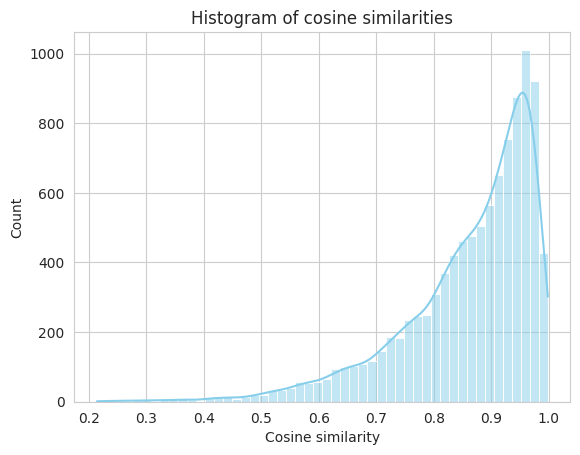

In [21]:
# Transpose and extract all cosine similarities
cosine_similarities_t = np.transpose(cosine_similarities)
cosine_similarities_raw = cosine_similarities_t[0]

# Set style
sns.set_style("whitegrid")

# Plot the histogram
sns.histplot(x=cosine_similarities_raw, bins=50, kde=True, color='skyblue')

# Set labels and title
plt.xlabel('Cosine similarity')
plt.ylabel('Count')
plt.title('Histogram of cosine similarities')

# Show the plot
plt.show()

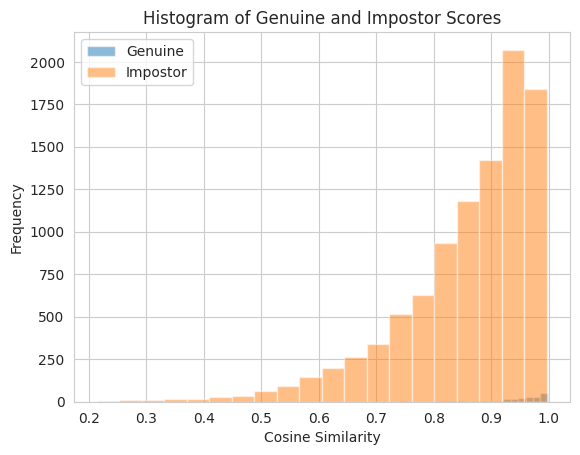

In [22]:
# Plot histograms for genuine and impostor scores
plt.hist(genuine_scores, bins=20, alpha=0.5, label='Genuine')
plt.hist(impostor_scores, bins=20, alpha=0.5, label='Impostor')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Histogram of Genuine and Impostor Scores')
plt.legend(loc='upper left')
plt.show()

###3) Calculate ROC AUC and d’ (d-prime) for the verification task on the testing dataset.###

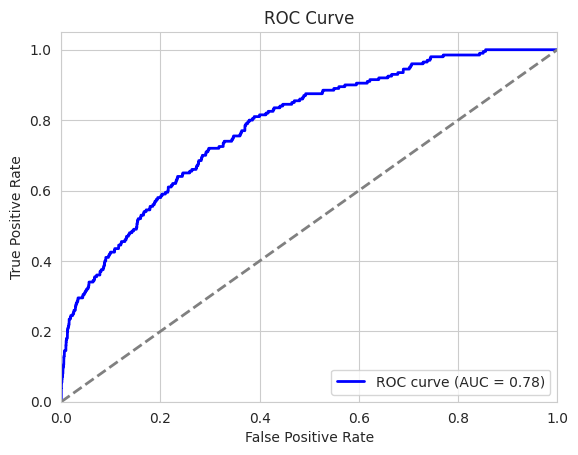

In [25]:
# Create ROC curve for genuine and impostor scores
fpr, tpr, thresholds = roc_curve(np.concatenate((np.ones(len(genuine_scores)), np.zeros(len(impostor_scores)))), 
                                 np.concatenate((genuine_scores, impostor_scores)))
roc_auc = auc(fpr, tpr)

# Calculate the optimal operating point on the ROC curve
optimal_idx = np.argmax(tpr - fpr)
OPTROCPT = (fpr[optimal_idx], tpr[optimal_idx])

# Plot ROC curve
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [27]:
# Set the threshold
threshold = 0.6

# Convert genuine_scores and impostor_scores to numpy arrays
genuine_scores = np.array(genuine_scores)
impostor_scores = np.array(impostor_scores)

# Create predictions based on threshold
predictions = np.concatenate((genuine_scores >= threshold, impostor_scores >= threshold))

# Calculate evaluation metrics
tp = np.sum(predictions[:len(genuine_scores)])
tn = np.sum(predictions[len(genuine_scores):])
fp = len(impostor_scores) - tn
fn = len(genuine_scores) - tp

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * precision * recall / (precision + recall)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1 Score: ', f1_score)


Accuracy:  0.9607
Precision:  0.3372681281618887
Recall:  1.0
F1 Score:  0.5044136191677175


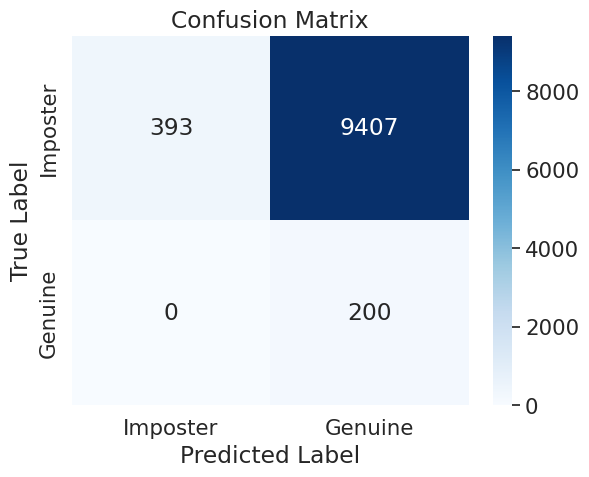

In [28]:
# Combine true labels for genuine and impostor scores
true_labels = [1] * len(genuine_scores) + [0] * len(impostor_scores)

# Combine predicted labels for genuine and impostor scores
predicted_labels = [1 if score >= threshold else 0 for score in genuine_scores] + [1 if score >= threshold else 0 for score in impostor_scores]

# Build confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Set labels for confusion matrix
labels = ['Imposter', 'Genuine']

# Set style for confusion matrix
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Set title and labels for confusion matrix
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show confusion matrix
plt.show()


In [29]:
# Calculating d-prime

from scipy.stats import norm

# Calculate mean and standard deviation of genuine scores
mean_genuine = np.mean(genuine_scores)
sd_genuine = np.std(genuine_scores)
print('Mean for Genuine score: {}'.format(mean_genuine))
print('Standard deviation for Genuine score: {}'.format(sd_genuine))

# Calculate mean and standard deviation of imposter scores
mean_imposter = np.mean(impostor_scores)
sd_imposter = np.std(impostor_scores)
print('Mean for Impostor score: {}'.format(mean_imposter))
print('Standard deviation for Impostor score: {}'.format(sd_imposter))

# Calculate z-scores for genuine and imposter means
z_genuine = (mean_genuine - mean_imposter) / np.sqrt((sd_genuine**2 + sd_imposter**2) / 2)
z_imposter = (mean_imposter - mean_genuine) / np.sqrt((sd_genuine**2 + sd_imposter**2) / 2)
print('z_genuine score : {}, z_imposter score: {}'. format(z_genuine, z_imposter))

# Calculate d-prime
d_prime = z_genuine - z_imposter

# Print d-prime value
print("d-prime: ", d_prime)

Mean for Genuine score: 0.9472004413604737
Standard deviation for Genuine score: 0.05304401839327285
Mean for Impostor score: 0.8590975818007576
Standard deviation for Impostor score: 0.11685310042116553
z_genuine score : 0.9709132325928583, z_imposter score: -0.9709132325928583
d-prime:  1.9418264651857167


In [30]:
original_data = cosine_similarities

# Define parameters
gallery_size = 200  # Number of rows to include for each probe
probe_size = 50  # Total number of probes (rows in the new object)

# Initialize the new object for the rank1 and rank5 identification calculations
cosine_similarities_probes = np.empty((probe_size, gallery_size, 2))

# Loop through the chunks
for i in range(probe_size):
    # Extract the corresponding chunk of rows from the original dataset
    start_index = i * gallery_size
    end_index = start_index + gallery_size
    chunk = original_data[start_index:end_index, :]

    # Sort the chunk based on the first column in descending order
    sorted_chunk = chunk[chunk[:, 0].argsort()[::-1]]

    # Store the sorted chunk in the new object
    cosine_similarities_probes[i] = sorted_chunk

# Print the new object
print(cosine_similarities_probes)
print(cosine_similarities_probes.shape)

[[[0.99370438 0.        ]
  [0.9905479  0.        ]
  [0.99036634 0.        ]
  ...
  [0.65779674 0.        ]
  [0.61089379 0.        ]
  [0.59354031 0.        ]]

 [[0.98425412 0.        ]
  [0.9825412  0.        ]
  [0.98024052 0.        ]
  ...
  [0.69849253 0.        ]
  [0.64852333 0.        ]
  [0.62906069 0.        ]]

 [[0.99622333 1.        ]
  [0.99334073 0.        ]
  [0.99330556 0.        ]
  ...
  [0.69060147 0.        ]
  [0.68395686 0.        ]
  [0.68169469 0.        ]]

 ...

 [[0.99528313 0.        ]
  [0.99179852 1.        ]
  [0.98999041 1.        ]
  ...
  [0.61768246 0.        ]
  [0.56819034 0.        ]
  [0.54977274 0.        ]]

 [[0.96911526 1.        ]
  [0.96474242 0.        ]
  [0.95765769 1.        ]
  ...
  [0.63988709 0.        ]
  [0.63210446 0.        ]
  [0.62796926 0.        ]]

 [[0.99760073 1.        ]
  [0.97799635 0.        ]
  [0.97257102 0.        ]
  ...
  [0.27446806 0.        ]
  [0.23967987 0.        ]
  [0.22482479 0.        ]]]
(50, 200, 

In [31]:
# Initialize the new object for the rank1 and rank5 identifications
rank1_identification = np.zeros(50)
rank5_identification = np.zeros(50)

# Initialize the new object for the rank1 and rank5 identifications using the optimal threshhold
rank1_identification_withThreshold = np.zeros(50)
rank5_identification_withThreshold = np.zeros(50)

# Iterate through the first axis of cosine_similarities_probes
for i in range(50):
    # Select the first element and retrieve the label of that selection
    rank1_identification[i] = (cosine_similarities_probes[i][0][1])

    # Iterate through the second axis of cosine_similarities_probes
    for j in range(5):
        # Retrieve the positive label if there is one
        if cosine_similarities_probes[i][j][1] == 1:
            rank5_identification[i] = (cosine_similarities_probes[i][j][1])

# Setting the threshhold for new rank1 and rank5 identifications
optimal_threshhold = fpr[optimal_idx]

# Iterate through the first axis of cosine_similarities_probes
for i in range(50):
    if optimal_threshhold < cosine_similarities_probes[i][0][0]:
        if cosine_similarities_probes[i][0][1] == 1:
            # Select the first element and retrieve the similarity score of that selection
            rank1_identification_withThreshold[i] = (cosine_similarities_probes[i][0][1])

    # Checking if all top 5 scores are above the optimal threshhold
    if optimal_threshhold < cosine_similarities_probes[i][4][0]:
        # Iterate through the second axis of cosine_similarities_probes
        for j in range(5):
            # Retrieve the positive label if there is one
            if cosine_similarities_probes[i][j][1] == 1:
                rank5_identification_withThreshold[i] = (cosine_similarities_probes[i][j][1])

# Calculating the identification rates
rank1_identification_rate = np.mean(rank1_identification)
rank5_identification_rate = np.mean(rank5_identification)
rank1_identification_withThreshold_rate = np.mean(rank1_identification_withThreshold)
rank5_identification_withThreshold_rate = np.mean(rank5_identification_withThreshold)

print(rank1_identification)
print(rank5_identification)
print(rank1_identification_withThreshold)
print(rank5_identification_withThreshold)

print(rank1_identification_rate)
print(rank5_identification_rate)
print(rank1_identification_withThreshold_rate)
print(rank5_identification_withThreshold_rate)

[0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 1. 1.]
[0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1.
 1. 1.]
[0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 1. 1.]
[0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1.
 1. 1.]
0.34
0.5
0.34
0.5
